In [ ]:
import numpy as np
import pandas as pd
import re
import glob

In [ ]:
# Function that takes in the JSON File and return a list of tuples where each tuple is (Run_Config, Omnetpp.ini, TargetsDictionary)

def JSONExtractor(JSON):
  runINI = []
  delINI = []
  ignore = []
  disk = "'peakdiskspaceusedbytes'"
  simRAM = "'peakramusedsimbytes'"
  resRAM = "'peakramusedresultsbytes'"
  time = "'totaljobclocktimesec'"

  for i in range(len(JSON)):
    
    # Checking if the Simulation_Completion and Results_Parsing_Completion are 100% and current state = 'COMPLETED'
    if ((JSON.simulations[i]['meta']['sim_completed_perc']==100) and (JSON.simulations[i]['meta']['results_completed_perc']==100) and (JSON.simulations[i]['meta']['current_state']=='COMPLETED')):

      # Checking if simulation contains meta data with 'sim_runtime_stats' as key (if not present 'totaljobclocktimesec' param can't be found, so discarding them)
      if 'sim_runtime_stats' in JSON.simulations[i]['meta']:

        # Fetching the all 4 targets variables from meta data of the simulation 
        dicts = {'peakdiskspaceusedbytes':re.compile(disk + r'\,\s([0-9\.]+)').findall(str(JSON.simulations[i]['meta']['sim_runtime_stats'])),
             'peakramusedsimbytes':re.compile(simRAM + r'\,\s([0-9\.]+)').findall(str(JSON.simulations[i]['meta']['sim_runtime_stats'])),
             'peakramusedresultsbytes':re.compile(resRAM + r'\,\s([0-9\.]+)').findall(str(JSON.simulations[i]['meta']['sim_runtime_stats'])),                                                                      
             'totaljobclocktimesec':re.compile(time + r'\,\s([0-9\.]+)').findall(str(JSON.simulations[i]['meta']['sim_runtime_stats'])) }
        
        # Appending Run_Config, Omnetpp.ini and Targets dictionary as a tuple in runINI list
        runINI.append((JSON.simulations[i]['runconfig'],JSON.simulations[i]['omnetppini'],dicts))
      else:
        ignore.append((JSON.simulations[i]['runconfig'],JSON.simulations[i]['omnetppini']))
    else:
      # print(i)
      # Appending info about incomplete simulations
      delINI.append((JSON.simulations[i]['runconfig'],JSON.simulations[i]['omnetppini'],dicts))

  return runINI

In [ ]:
# Function that takes in Run_Config, .ini, TargetsDictionary and returns a dictionary of all .ini parameters 
# of a simulation along with their corresponding targets

def FeatureExtractor(runconfig,omnetppini,targets):
  if not runconfig == 'General':
    # print(runconfig)
    # replacing multiple \r and \n with null and \n resp. and splitting on \n basis
    splitINI = re.sub(r'[\n]+','\n ',re.sub(r'[\r]+','',omnetppini)).strip().split('\n')

    # INI filtering (removes any redundant commands/comments starting with '#' in the ini) 
    refreshINI = ''.join([line.strip() for line in splitINI if not line.strip().startswith('#')])

    # RunConfig Filtering (Filter INI for the specific RunConfig) --- case where mutiple Run_Configs 
    # are present in same ini file
    configFiltered = re.compile(runconfig + r'[\'\]\n\#\s\w\*\.=\(\)\"\,\-\/\+]+').findall(refreshINI)

    # Extracting every ini param and converting to dict
    paramDict = dict(re.findall(r'\*\*\.([a-zA-Z\.]+) = ([A-Za-z0-9\"\.\/\-]+)',str(configFiltered)))
    if 'numNodes' not in paramDict.keys():
      x = re.findall(r'\*\*\.(numNodes) = ([0-9]+)',refreshINI)[0]
      paramDict[x[0]] = x[1]

    # Combining .ini parameters dictionary with TargetsDictionary
    paramDict.update(targets)

    return paramDict

In [ ]:
# previous = pd.read_csv('/content/drive/MyDrive/OOTB/FinaldataWithDummy.csv')
previous = pd.read_csv('/content/drive/MyDrive/OOTB/Data_27_02_2023.csv')
previous = previous[(previous.numNodes!=0)]
previous.reset_index(inplace=True,drop=True)
previous.columns = previous.columns.str.replace('"','')
previous.mobility_nodeId = previous.mobility_nodeId.replace(-1,1)
previous.columns = previous.columns.str.replace('mobilityType_0','mobilityType_ContactTraces')

In [ ]:
previous.columns

Index(['app_dataGenerationInterval', 'constraintAreaMaxX',
       'constraintAreaMaxY', 'mobility_noOfLocations', 'mobility_Hosts',
       'mobility_speed', 'numNodes', 'app_dataSizeInBytes',
       'forwarding_maximumCacheSize', 'peakdiskspaceusedbytes',
       'peakramusedsimbytes', 'peakramusedresultsbytes',
       'totaljobclocktimesec', 'mobility_nodeId',
       'applicationLayer_KHeraldAppForDifferentiatedTraffic',
       'applicationLayer_KMessengerApp', 'forwardingLayer_KKeetchiLayer',
       'forwardingLayer_KOptimumDelayRoutingLayer',
       'forwardingLayer_KProphetRoutingLayer', 'forwardingLayer_KRRSLayer',
       'forwardingLayer_KSpraywaitRoutingLayer',
       'linkLayer_KWirelessInterfaceWithContactTraces',
       'mobilityType_SWIMMobility', 'mobilityType_ContactTraces'],
      dtype='object')

In [ ]:
JSONDrives = glob.glob('/content/drive/MyDrive/OOTB/simulation-meta_26_02_2023.json')
print(len(JSONDrives))
JSONDrives

1


['/content/drive/MyDrive/OOTB/simulation-meta_26_02_2023.json']

In [ ]:
finalDic = []
inis = []
runconfig = []
for path in JSONDrives:
  try:
    json = pd.read_json(path)
    print(JSONDrives[-1])
    JsonFiltered = JSONExtractor(json)
    # print("Initial Length of JSON",len(json),"Final Length of Filtered JSON",len(JsonFiltered))

    # ParamsList = []
    for rc,ini,targets in JsonFiltered:
      # Feature Extractor function returns .ini params and targets as dictionary
      dic = FeatureExtractor(rc,ini,targets)
      if bool(dic):
        # ParamsList.append(dic)
        inis.append(ini)
        runconfig.append(rc)
        finalDic.append(dic)
  except:
    # print(path)
    print("ss")

/content/drive/MyDrive/OOTB/simulation-meta_26_02_2023.json


In [ ]:
Numericals = ['app_dataGenerationInterval','constraintAreaMaxX','constraintAreaMaxY','mobility_noOfLocations','mobility_Hosts','mobility_speed','numNodes','app_dataSizeInBytes','forwarding_maximumCacheSize','mobility_nodeId']
Categoricals = ['applicationLayer','forwardingLayer','linkLayer','mobilityType']
Targets = ['peakdiskspaceusedbytes','peakramusedsimbytes','peakramusedresultsbytes','totaljobclocktimesec']

In [ ]:
first = pd.DataFrame(finalDic)
first

,numNodes,applicationLayer,app.ttl,app.popularityAssignmentPercentage,app.dataGenerationInterval,app.dataSizeInBytes,app.usedRNG,app.dataGenerationIntervalMode,app.trafficInfoPath,forwardingLayer,forwarding.agingInterval,forwarding.maximumCacheSize,forwarding.neighbourhoodChangeSignificanceThreshold,forwarding.coolOffDuration,forwarding.learningConst,forwarding.backoffTimerIncrementFactor,forwarding.usedRNG,linkLayer,link.wirelessRange,link.neighbourScanInterval,link.bandwidthBitRate,link.wirelessHeaderSize,link.usedRNG,mobilityType,mobility.traceFile,mobility.nodeId,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec,forwarding.antiEntropyInterval,forwarding.maximumHopCount,forwarding.pEncounterMax,forwarding.pEncounterFirst,forwarding.pFirstThreshold,forwarding.alpha,forwarding.beta,forwarding.gamma,forwarding.delta,forwarding.standardTimeInterval,constraintAreaMinX,constraintAreaMinY,constraintAreaMinZ,constraintAreaMaxX,constraintAreaMaxY,constraintAreaMaxZ,updateInterval,mobility.initFromDisplayString,mobility.noOfLocations,mobility.Hosts,mobility.popularityDecisionThreshold,mobility.returnHomePercentage,mobility.neighbourLocationLimit,mobility.speed,mobility.radius,mobility.alpha,mobility.waitTime,mobility.usedRNG,forwarding.spraywaitFlavour,forwarding.noDuplicate,forwarding.broadcastRRS,forwarding.sendOnNeighReportingFrequency,forwarding.sendFrequencyWhenNotOnNeighFrequency,forwarding.useTTL,link.contactTracesPath,app.specificDestination,app.specificDestinationNodeName
0,3600,"""KHeraldApp""",259200,25,90s,100000,1,"""trace""","""/opt/traces/benchmarks/scenario-02-typhoon/Sc...","""KKeetchiLayer""",600s,10000000byte,0.25,300s,0.5,1.5,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""BonnMotionMobility""","""/opt/traces/benchmarks/scenario-02-typhoon/Tr...",-1,[484271715770],[93930082304],[273039560704],[346805.421805],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,550,"""KHeraldApp""",259200,25,1s,10000,1,NaN,NaN,"""KProphetRoutingLayer""",NaN,5000000byte,NaN,NaN,NaN,NaN,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""SWIMMobility""",NaN,NaN,[258711419121],[153773088768],[67183632384],[115619.118172],300s,25,0.7,0.5,0.1,0.5,0.9,0.998,0.1,3600s,0m,0m,0m,1000m,1000m,0m,1s,false,400,200,7,15,200m,1.5mps,2m,0.5,uniform,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,600,"""KMessengerApp""",NaN,NaN,90s,10000,1,NaN,NaN,"""KProphetRoutingLayer""",NaN,5000000byte,NaN,NaN,NaN,NaN,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""SWIMMobility""",NaN,NaN,[104395123367],[279368515584],[48105594880],[173105.656201],300s,25,0.7,0.5,0.1,0.5,0.9,0.998,0.1,3600s,0m,0m,0m,1000m,1000m,0m,1s,false,150,50,7,15,200m,1.5mps,2m,0.5,uniform,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,550,"""KHeraldApp""",259200,25,1s,10000,1,NaN,NaN,"""KSpraywaitRoutingLayer""",NaN,100000byte,NaN,NaN,NaN,NaN,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""SWIMMobility""",NaN,NaN,[296018130247],[35628666880],[62481670144],[44848.37865],300s,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0m,0m,0m,1000m,1000m,0m,1s,false,300,300,7,15,200m,1mps,2m,0.5,uniform,5,"""binary""",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,"""KHeraldApp""",259200,25,1s,10000,1,NaN,NaN,"""KRRSLayer""",NaN,1000000byte,NaN,NaN,NaN,NaN,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""SWIMMobility""",NaN,NaN,[443172998044],[33202454528],[89929977856],[76910.138975],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0m,0m,0m,1000m,1000m,0m,1s,false,300,500,7,15,200m,3.5mps,2m,0.5,uniform,5,NaN,NaN,false,false,4s,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,400,"""KMessengerApp""",NaN,NaN,30s,100000,1,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
for_null = first[first['forwardingLayer'].isna()]
for_null

,numNodes,applicationLayer,app.ttl,app.popularityAssignmentPercentage,app.dataGenerationInterval,app.dataSizeInBytes,app.usedRNG,app.dataGenerationIntervalMode,app.trafficInfoPath,forwardingLayer,forwarding.agingInterval,forwarding.maximumCacheSize,forwarding.neighbourhoodChangeSignificanceThreshold,forwarding.coolOffDuration,forwarding.learningConst,forwarding.backoffTimerIncrementFactor,forwarding.usedRNG,linkLayer,link.wirelessRange,link.neighbourScanInterval,link.bandwidthBitRate,link.wirelessHeaderSize,link.usedRNG,mobilityType,mobility.traceFile,mobility.nodeId,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec,forwarding.antiEntropyInterval,forwarding.maximumHopCount,forwarding.pEncounterMax,forwarding.pEncounterFirst,forwarding.pFirstThreshold,forwarding.alpha,forwarding.beta,forwarding.gamma,forwarding.delta,forwarding.standardTimeInterval,constraintAreaMinX,constraintAreaMinY,constraintAreaMinZ,constraintAreaMaxX,constraintAreaMaxY,constraintAreaMaxZ,updateInterval,mobility.initFromDisplayString,mobility.noOfLocations,mobility.Hosts,mobility.popularityDecisionThreshold,mobility.returnHomePercentage,mobility.neighbourLocationLimit,mobility.speed,mobility.radius,mobility.alpha,mobility.waitTime,mobility.usedRNG,forwarding.spraywaitFlavour,forwarding.noDuplicate,forwarding.broadcastRRS,forwarding.sendOnNeighReportingFrequency,forwarding.sendFrequencyWhenNotOnNeighFrequency,forwarding.useTTL,link.contactTracesPath,app.specificDestination,app.specificDestinationNodeName
100,550,"""KMessengerApp""",NaN,NaN,90s,100000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[103698610143],[20982284288],[45440446464],[17960.193785],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true,"""host"
102,450,"""KMessengerApp""",NaN,NaN,1s,100000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[84897810872],[19223175168],[30879481856],[15780.891466],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true,"""host"
104,450,"""KMessengerApp""",NaN,NaN,1s,100000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[84897758436],[19223175168],[30879481856],[15495.60074],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true,"""host"
123,550,"""KMessengerApp""",NaN,NaN,90s,100000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[103698348719],[20982284288],[45440446464],[17190.10973],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true,"""host"
128,450,"""KMessengerApp""",NaN,NaN,1s,100000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[84897653578],[19223175168],[30879481856],[15065.579751],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true,"""host"
131,450,"""KMessengerApp""",NaN,NaN,1s,100000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[84897310271],[19223175168],[30879481856],[15227.64955],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true,"""host"
132,400,"""KMessengerApp""",NaN,NaN,30s,100000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[107221447852],[11825553408],[34118213632],[23949.801568],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true,"""host"


In [ ]:
# print(runconfig[328])
# print(for_null.index)
# print(inis[328])
# # for index in for_null.index.values:
# #   print(runconfig[index])
# runconfigs = runconfig[313]
# splitINI = re.sub(r'[\n]+','\n ',re.sub(r'[\r]+','',inis[313])).strip().split('\n')
# refreshINI = ''.join([line.strip() for line in splitINI if not line.strip().startswith('#')])
# re.compile(runconfigs + r'[\]\n\#\s\w\*\.=\(\)\"\,\-\/\+]+').findall(refreshINI)

In [ ]:
second = first[~first['forwardingLayer'].isna()]
second

,numNodes,applicationLayer,app.ttl,app.popularityAssignmentPercentage,app.dataGenerationInterval,app.dataSizeInBytes,app.usedRNG,app.dataGenerationIntervalMode,app.trafficInfoPath,forwardingLayer,forwarding.agingInterval,forwarding.maximumCacheSize,forwarding.neighbourhoodChangeSignificanceThreshold,forwarding.coolOffDuration,forwarding.learningConst,forwarding.backoffTimerIncrementFactor,forwarding.usedRNG,linkLayer,link.wirelessRange,link.neighbourScanInterval,link.bandwidthBitRate,link.wirelessHeaderSize,link.usedRNG,mobilityType,mobility.traceFile,mobility.nodeId,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec,forwarding.antiEntropyInterval,forwarding.maximumHopCount,forwarding.pEncounterMax,forwarding.pEncounterFirst,forwarding.pFirstThreshold,forwarding.alpha,forwarding.beta,forwarding.gamma,forwarding.delta,forwarding.standardTimeInterval,constraintAreaMinX,constraintAreaMinY,constraintAreaMinZ,constraintAreaMaxX,constraintAreaMaxY,constraintAreaMaxZ,updateInterval,mobility.initFromDisplayString,mobility.noOfLocations,mobility.Hosts,mobility.popularityDecisionThreshold,mobility.returnHomePercentage,mobility.neighbourLocationLimit,mobility.speed,mobility.radius,mobility.alpha,mobility.waitTime,mobility.usedRNG,forwarding.spraywaitFlavour,forwarding.noDuplicate,forwarding.broadcastRRS,forwarding.sendOnNeighReportingFrequency,forwarding.sendFrequencyWhenNotOnNeighFrequency,forwarding.useTTL,link.contactTracesPath,app.specificDestination,app.specificDestinationNodeName
0,3600,"""KHeraldApp""",259200,25,90s,100000,1,"""trace""","""/opt/traces/benchmarks/scenario-02-typhoon/Sc...","""KKeetchiLayer""",600s,10000000byte,0.25,300s,0.5,1.5,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""BonnMotionMobility""","""/opt/traces/benchmarks/scenario-02-typhoon/Tr...",-1,[484271715770],[93930082304],[273039560704],[346805.421805],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,550,"""KHeraldApp""",259200,25,1s,10000,1,NaN,NaN,"""KProphetRoutingLayer""",NaN,5000000byte,NaN,NaN,NaN,NaN,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""SWIMMobility""",NaN,NaN,[258711419121],[153773088768],[67183632384],[115619.118172],300s,25,0.7,0.5,0.1,0.5,0.9,0.998,0.1,3600s,0m,0m,0m,1000m,1000m,0m,1s,false,400,200,7,15,200m,1.5mps,2m,0.5,uniform,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,600,"""KMessengerApp""",NaN,NaN,90s,10000,1,NaN,NaN,"""KProphetRoutingLayer""",NaN,5000000byte,NaN,NaN,NaN,NaN,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""SWIMMobility""",NaN,NaN,[104395123367],[279368515584],[48105594880],[173105.656201],300s,25,0.7,0.5,0.1,0.5,0.9,0.998,0.1,3600s,0m,0m,0m,1000m,1000m,0m,1s,false,150,50,7,15,200m,1.5mps,2m,0.5,uniform,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,550,"""KHeraldApp""",259200,25,1s,10000,1,NaN,NaN,"""KSpraywaitRoutingLayer""",NaN,100000byte,NaN,NaN,NaN,NaN,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""SWIMMobility""",NaN,NaN,[296018130247],[35628666880],[62481670144],[44848.37865],300s,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0m,0m,0m,1000m,1000m,0m,1s,false,300,300,7,15,200m,1mps,2m,0.5,uniform,5,"""binary""",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,"""KHeraldApp""",259200,25,1s,10000,1,NaN,NaN,"""KRRSLayer""",NaN,1000000byte,NaN,NaN,NaN,NaN,3,"""KWirelessInterface""",30m,1s,100000bps,16byte,4,"""SWIMMobility""",NaN,NaN,[443172998044],[33202454528],[89929977856],[76910.138975],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0m,0m,0m,1000m,1000m,0m,1s,false,300,500,7,15,200m,3.5mps,2m,0.5,uniform,5,NaN,NaN,false,false,4s,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,600,"""KMessengerApp""",NaN,NaN,9s,1000000,1,NaN,NaN,"""KKeetchiLay

In [ ]:
second.columns = second.columns.str.replace('.','_',regex=False)

remove_cols = ['app_popularityAssignmentPercentage','app_usedRNG','forwarding_antiEntropyInterval','forwarding_maximumHopCount','forwarding_usedRNG','link_wirelessRange','link_neighbourScanInterval','link_bandwidthBitRate','link_wirelessHeaderSize','link_usedRNG','constraintAreaMinX','constraintAreaMinY','constraintAreaMinZ','constraintAreaMaxZ','updateInterval','mobility_initFromDisplayString','mobility_popularityDecisionThreshold','mobility_returnHomePercentage','mobility_neighbourLocationLimit','mobility_radius','mobility_alpha','mobility_waitTime','mobility_usedRNG','app_dataGenerationIntervalMode','app_trafficInfoPath','forwarding_spraywaitFlavour','forwarding_noDuplicate','mobility_traceFile','link_contactTracesPath','forwarding_broadcastRRS','forwarding_sendOnNeighReportingFrequency','forwarding_sendFrequencyWhenNotOnNeighFrequency','forwarding_pEncounterMax','forwarding_pEncounterFirst','forwarding_pFirstThreshold','forwarding_alpha','forwarding_beta','forwarding_gamma','forwarding_delta','forwarding_standardTimeInterval','forwarding_agingInterval','forwarding_neighbourhoodChangeSignificanceThreshold','forwarding_coolOffDuration','forwarding_learningConst','forwarding_backoffTimerIncrementFactor','app_specificDestination','app_specificDestinationNodeName','app_ttl','forwarding_useTTL']

leftover_cols = [col for col in second.columns if col not in remove_cols]

# Different coulmn categories
Numericals = ['app_dataGenerationInterval','constraintAreaMaxX','constraintAreaMaxY','mobility_noOfLocations','mobility_Hosts','mobility_speed','numNodes','app_dataSizeInBytes','forwarding_maximumCacheSize','mobility_nodeId']
Categoricals = ['applicationLayer','forwardingLayer','linkLayer','mobilityType']
Targets = ['peakdiskspaceusedbytes','peakramusedsimbytes','peakramusedresultsbytes','totaljobclocktimesec']

# Seprating dataframe with required columns
third = second[leftover_cols]

In [ ]:
third.mobilityType = third.mobilityType.fillna("ContactTraces")
third.mobility_nodeId = third.mobility_nodeId.fillna('0').str.replace('-1','1')
third.constraintAreaMaxX = third.constraintAreaMaxX.fillna('0')
third.constraintAreaMaxY = third.constraintAreaMaxY.fillna('0')
third.mobility_noOfLocations = third.mobility_noOfLocations.fillna('0')
third.mobility_Hosts = third.mobility_Hosts.fillna('0')
third.mobility_speed = third.mobility_speed.fillna('0')
third.forwarding_maximumCacheSize = third.forwarding_maximumCacheSize.fillna('0')

In [ ]:
one_hots = pd.get_dummies(third[Categoricals],drop_first=True)
fourth = pd.concat([third,one_hots],axis=1)
fourth = fourth.drop(Categoricals,axis=1)

In [ ]:
# Changing Numerical features from strings to integers
fourth['app_dataGenerationInterval'] =  fourth.app_dataGenerationInterval.apply(lambda x : x.replace('s','') if 's' in x else x)
fourth['constraintAreaMaxX'] =  fourth.constraintAreaMaxX.apply(lambda x : x.replace('m','') if 'm' in x else x)
fourth['constraintAreaMaxY'] =  fourth.constraintAreaMaxY.apply(lambda x : x.replace('m','') if 'm' in x else x)
fourth['mobility_speed'] =  fourth.mobility_speed.apply(lambda x : x.replace('mps','') if 'mps' in x else x)
def for_maxCache(cache):
  if 'bytes' in str(cache):
    return cache.replace('bytes','')
  elif 'byte' in str(cache):
    return cache.replace('byte','')
  else:
    return cache
fourth['forwarding_maximumCacheSize'] =  fourth.forwarding_maximumCacheSize.apply(lambda x : for_maxCache(x))

In [ ]:
#Separating features from the dataset and changing their datatype
features = fourth.drop(Targets,axis=1)
fourth[features.columns] = features.apply(pd.to_numeric)

# Changing Target variables from string to integers
def target_list(target):
  if type(target) is list:
    return pd.to_numeric(target[0],errors='coerce')
for col in Targets:
  fourth[col] = fourth[col].apply(lambda x: target_list(x))

In [ ]:
fourth.columns = fourth.columns.str.replace('"','')
fourth = fourth.reset_index(drop=True)
fourth

,numNodes,app_dataGenerationInterval,app_dataSizeInBytes,forwarding_maximumCacheSize,mobility_nodeId,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec,constraintAreaMaxX,constraintAreaMaxY,mobility_noOfLocations,mobility_Hosts,mobility_speed,applicationLayer_KHeraldAppForDifferentiatedTraffic,applicationLayer_KMessengerApp,forwardingLayer_KKeetchiLayer,forwardingLayer_KOptimumDelayRoutingLayer,forwardingLayer_KProphetRoutingLayer,forwardingLayer_KRRSLayer,forwardingLayer_KSpraywaitRoutingLayer,linkLayer_KWirelessInterfaceWithContactTraces,mobilityType_SWIMMobility,mobilityType_ContactTraces
0,3600,90,100000,10000000,1,484271715770,93930082304,273039560704,346805.421805,0,0,0,0,0.0,0,0,1,0,0,0,0,0,0,0
1,550,1,10000,5000000,0,258711419121,153773088768,67183632384,115619.118172,1000,1000,400,200,1.5,0,0,0,0,1,0,0,0,1,0
2,600,90,10000,5000000,0,104395123367,279368515584,48105594880,173105.656201,1000,1000,150,50,1.5,0,1,0,0,1,0,0,0,1,0
3,550,1,10000,100000,0,296018130247,35628666880,62481670144,44848.378650,1000,1000,300,300,1.0,0,0,0,0,0,0,1,0,1,0
4,550,1,10000,1000000,0,443172998044,33202454528,89929977856,76910.138975,1000,1000,300,500,3.5,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,600,9,1000000,10000000,0,134920240727,28071956480,51360202752,25598.185672,1500,1500,100,500,1.5,0,1,1,0,0,0,0,0,1,0
126,3600,1,10000,100000000,1,237812629975,102489124864,106308476928,130533.655211,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0
127,62,1,10000,100000000,0,452122011,2906562560,105046016,56.815197,0,0,0,0,0.0,1,0,1,0,0,0,0,1,0,1
128,54,1,10000,100000000,0,8475143671,2291933184,3783286784,911.656508,0,0,0,0,0.0,1,0,0,0,0,0,0,1,0,1


In [ ]:
# fourth.mobilityType_SWIMMobility==1]

In [ ]:
#Save the dataset into the drive
# fourth.to_csv('/content/drive/MyDrive/OOTB/DataWithDummy_26_02_2023.csv',index=False)

MERGER CURRENT + PREVIOUS

In [ ]:
# print(previous.columns)
# print(fourth.columns)

In [ ]:
merge = pd.concat([previous,fourth],axis=0).reset_index(drop=True)
merge

,app_dataGenerationInterval,constraintAreaMaxX,constraintAreaMaxY,mobility_noOfLocations,mobility_Hosts,mobility_speed,numNodes,app_dataSizeInBytes,forwarding_maximumCacheSize,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec,mobility_nodeId,applicationLayer_KHeraldAppForDifferentiatedTraffic,applicationLayer_KMessengerApp,forwardingLayer_KKeetchiLayer,forwardingLayer_KOptimumDelayRoutingLayer,forwardingLayer_KProphetRoutingLayer,forwardingLayer_KRRSLayer,forwardingLayer_KSpraywaitRoutingLayer,linkLayer_KWirelessInterfaceWithContactTraces,mobilityType_SWIMMobility,mobilityType_ContactTraces
0,9,1500,1500,200,1000,15.0,50,60400,204000000,11634223897,3999662080,3854192640,2592.588410,0,0,0,0,0,0,0,0,0,1,0
1,9,1500,1500,200,1000,15.0,50,60400,801000000,11662665740,4420177920,3851526144,4195.535410,0,0,0,0,0,0,0,0,0,1,0
2,9,1500,1500,200,1000,15.0,430,80200,801000000,113247869508,104445530112,33005178880,138686.803866,0,0,0,0,0,0,0,0,0,1,0
3,9,1500,1500,200,1000,15.0,430,80200,204000000,112093638975,68719665152,32938033152,78209.559370,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0.0,3600,10000,100000000,219293035922,65202200576,104601632768,125719.890218,1,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,9,1500,1500,100,500,1.5,600,1000000,10000000,134920240727,28071956480,51360202752,25598.185672,0,0,1,1,0,0,0,0,0,1,0
712,1,0,0,0,0,0.0,3600,10000,100000000,237812629975,102489124864,106308476928,130533.655211,1,1,0,0,0,0,0,0,0,0,0
713,1,0,0,0,0,0.0,62,10000,100000000,452122011,2906562560,105046016,56.815197,0,1,0,1,0,0,0,0,1,0,1
714,1,0,0,0,0,0.0,54,10000,100000000,8475143671,2291933184,3783286784,911.656508,0,1,0,0,0,0,0,0,1,0,1


In [ ]:
less70 = merge[merge.numNodes<=70].sample(250)

In [ ]:
great70 = merge[merge.numNodes>70]

In [ ]:
merge = pd.concat([less70,great70],axis=0).reset_index(drop=True)
merge

,app_dataGenerationInterval,constraintAreaMaxX,constraintAreaMaxY,mobility_noOfLocations,mobility_Hosts,mobility_speed,numNodes,app_dataSizeInBytes,forwarding_maximumCacheSize,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec,mobility_nodeId,applicationLayer_KHeraldAppForDifferentiatedTraffic,applicationLayer_KMessengerApp,forwardingLayer_KKeetchiLayer,forwardingLayer_KOptimumDelayRoutingLayer,forwardingLayer_KProphetRoutingLayer,forwardingLayer_KRRSLayer,forwardingLayer_KSpraywaitRoutingLayer,linkLayer_KWirelessInterfaceWithContactTraces,mobilityType_SWIMMobility,mobilityType_ContactTraces
0,90,500,500,100,50,1.5,10,10000,100000000,1526351178,681267200,762765312,130.187741,0,0,0,1,0,0,0,0,0,1,0
1,9,1500,1500,200,500,15.0,50,10000,5000000,9734245669,2370682880,3817926656,839.684548,0,0,1,0,0,0,1,0,0,1,0
2,90,1500,1500,200,50,1.0,30,10000,5000000,4581708176,1648312320,1697021952,479.083264,0,0,1,0,0,0,0,1,0,1,0
3,9,1000,1000,100,50,1.0,50,10000,5000000,8117101701,2691747840,3809882112,927.776051,0,0,1,0,0,0,0,1,0,1,0
4,1,0,0,0,0,0.0,54,10000,100300000,8441559383,2285195264,3782946816,815.904360,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,1,700,700,200,300,1.0,700,100000,5000000,134844607894,37862445056,53695074304,61177.139505,0,0,1,0,0,0,0,1,0,1,0
638,1,500,500,500,600,3.5,650,100000,5000000,393476197435,43749421056,74999005184,75551.311526,0,0,0,0,0,0,0,0,0,1,0
639,9,1000,1000,300,700,1.5,700,1000000,5000000,152076691422,41691275264,55636951040,35587.836961,0,0,0,0,0,0,0,0,0,1,0
640,9,1500,1500,100,500,1.5,600,1000000,10000000,134920240727,28071956480,51360202752,25598.185672,0,0,1,1,0,0,0,0,0,1,0


In [ ]:
# merge = merge[merge.mobilityType_SWIMMobility==1].reset_index(drop=True)
# merge

In [ ]:
fifth = merge.copy(deep=True)
# fifth = previous.copy(deep=True)
fifth

,app_dataGenerationInterval,constraintAreaMaxX,constraintAreaMaxY,mobility_noOfLocations,mobility_Hosts,mobility_speed,numNodes,app_dataSizeInBytes,forwarding_maximumCacheSize,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec,mobility_nodeId,applicationLayer_KHeraldAppForDifferentiatedTraffic,applicationLayer_KMessengerApp,forwardingLayer_KKeetchiLayer,forwardingLayer_KOptimumDelayRoutingLayer,forwardingLayer_KProphetRoutingLayer,forwardingLayer_KRRSLayer,forwardingLayer_KSpraywaitRoutingLayer,linkLayer_KWirelessInterfaceWithContactTraces,mobilityType_SWIMMobility,mobilityType_ContactTraces
0,90,500,500,100,50,1.5,10,10000,100000000,1526351178,681267200,762765312,130.187741,0,0,0,1,0,0,0,0,0,1,0
1,9,1500,1500,200,500,15.0,50,10000,5000000,9734245669,2370682880,3817926656,839.684548,0,0,1,0,0,0,1,0,0,1,0
2,90,1500,1500,200,50,1.0,30,10000,5000000,4581708176,1648312320,1697021952,479.083264,0,0,1,0,0,0,0,1,0,1,0
3,9,1000,1000,100,50,1.0,50,10000,5000000,8117101701,2691747840,3809882112,927.776051,0,0,1,0,0,0,0,1,0,1,0
4,1,0,0,0,0,0.0,54,10000,100300000,8441559383,2285195264,3782946816,815.904360,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,1,700,700,200,300,1.0,700,100000,5000000,134844607894,37862445056,53695074304,61177.139505,0,0,1,0,0,0,0,1,0,1,0
638,1,500,500,500,600,3.5,650,100000,5000000,393476197435,43749421056,74999005184,75551.311526,0,0,0,0,0,0,0,0,0,1,0
639,9,1000,1000,300,700,1.5,700,1000000,5000000,152076691422,41691275264,55636951040,35587.836961,0,0,0,0,0,0,0,0,0,1,0
640,9,1500,1500,100,500,1.5,600,1000000,10000000,134920240727,28071956480,51360202752,25598.185672,0,0,1,1,0,0,0,0,0,1,0


In [ ]:
#Save the dataset into the drive
# fifth.to_csv('/content/drive/MyDrive/OOTB/Data_27_02_2023.csv',index=False)

Pre-Processing DATA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew, johnsonsu, lognorm
from scipy.special import boxcox1p,inv_boxcox1p

In [ ]:
fifth.columns

Index(['app_dataGenerationInterval', 'constraintAreaMaxX',
       'constraintAreaMaxY', 'mobility_noOfLocations', 'mobility_Hosts',
       'mobility_speed', 'numNodes', 'app_dataSizeInBytes',
       'forwarding_maximumCacheSize', 'peakdiskspaceusedbytes',
       'peakramusedsimbytes', 'peakramusedresultsbytes',
       'totaljobclocktimesec', 'mobility_nodeId',
       'applicationLayer_KHeraldAppForDifferentiatedTraffic',
       'applicationLayer_KMessengerApp', 'forwardingLayer_KKeetchiLayer',
       'forwardingLayer_KOptimumDelayRoutingLayer',
       'forwardingLayer_KProphetRoutingLayer', 'forwardingLayer_KRRSLayer',
       'forwardingLayer_KSpraywaitRoutingLayer',
       'linkLayer_KWirelessInterfaceWithContactTraces',
       'mobilityType_SWIMMobility', 'mobilityType_ContactTraces'],
      dtype='object')

<AxesSubplot:xlabel='mobility_nodeId', ylabel='Count'>

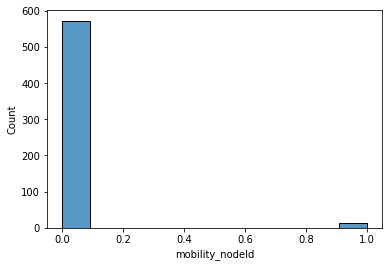

In [ ]:
# MobilityNodeID=1 for BONN_MOTION_MOBILITY simualtions
sns.histplot(fifth['mobility_nodeId'],stat='count')

In [ ]:
## Skewness of all features

# Check the skew of all numerical features
skewed_feats = fifth[Numericals].apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
mobility_nodeId,6.235513
forwarding_maximumCacheSize,5.991713
numNodes,5.443172
app_dataSizeInBytes,2.984550
app_dataGenerationInterval,1.953156
mobility_speed,1.432027
mobility_Hosts,1.203036
mobility_noOfLocations,0.947243
constraintAreaMaxY,0.065979
constraintAreaMaxX,0.055859


In [ ]:
## Applying BoxCox transforms

skewness = skewness[abs(skewness['Skew'].values) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
  print(feat)
  #all_data[feat] += 1
  fifth[feat] = boxcox1p(fifth[feat], lam)

There are 8 skewed numerical features to Box Cox transform
mobility_nodeId
forwarding_maximumCacheSize
numNodes
app_dataSizeInBytes
app_dataGenerationInterval
mobility_speed
mobility_Hosts
mobility_noOfLocations


In [ ]:
# Check the NEW skew of all numerical features
skewed_feats = fifth[Numericals].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
mobility_nodeId,6.235513
app_dataSizeInBytes,2.041558
app_dataGenerationInterval,1.030222
numNodes,0.905337
mobility_speed,0.573419
constraintAreaMaxY,0.065979
constraintAreaMaxX,0.055859
mobility_Hosts,-0.269086
forwarding_maximumCacheSize,-0.418713
mobility_noOfLocations,-0.697092


In [ ]:
sixth = fifth.copy(deep=True)
sixth

,app_dataGenerationInterval,constraintAreaMaxX,constraintAreaMaxY,mobility_noOfLocations,mobility_Hosts,mobility_speed,numNodes,app_dataSizeInBytes,forwarding_maximumCacheSize,peakdiskspaceusedbytes,...,applicationLayer_KHeraldAppForDifferentiatedTraffic,applicationLayer_KMessengerApp,forwardingLayer_KKeetchiLayer,forwardingLayer_KOptimumDelayRoutingLayer,forwardingLayer_KProphetRoutingLayer,forwardingLayer_KRRSLayer,forwardingLayer_KSpraywaitRoutingLayer,linkLayer_KWirelessInterfaceWithContactTraces,mobilityType_SWIMMobility,mobilityType_ContactTraces
0,2.750250,1500,1500,8.103594,12.125370,3.438110,5.357203,28.092180,110.918697,11634223897,...,0,0,0,0,0,0,0,0,1,0
1,2.750250,1500,1500,8.103594,12.125370,3.438110,5.357203,28.092180,137.695575,11662665740,...,0,0,0,0,0,0,0,0,1,0
2,2.750250,1500,1500,8.103594,12.125370,3.438110,9.894096,29.602344,137.695575,113247869508,...,0,0,0,0,0,0,0,0,1,0
3,2.750250,1500,1500,8.103594,12.125370,3.438110,9.894096,29.602344,110.918697,112093638975,...,0,0,0,0,0,0,0,0,1,0
4,0.730463,0,0,0.000000,0.000000,0.000000,16.103815,19.874209,98.992880,219293035922,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,2.750250,1000,1000,9.025890,11.147538,0.982247,11.147538,46.288557,60.747979,152076691422,...,0,0,0,0,0,0,0,0,1,0
582,2.750250,1500,1500,6.654950,10.272202,0.982247,10.740974,46.288557,68.134565,134920240727,...,0,1,1,0,0,0,0,0,1,0
583,0.730463,0,0,0.000000,0.000000,0.000000,5.744420,19.874209,98.992880,452122011,...,1,0,1,0,0,0,0,1,0,1
584,0.730463,0,0,0.000000,0.000000,0.000000,5.494161,19.874209,98.992880,8475143671,...,1,0,0,0,0,0,0,1,0,1


In [ ]:
# sixth.info()

Modelling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam,Ftrl
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from keras.utils import plot_model
from sklearn.metrics import make_scorer,accuracy_score
from sklearn.model_selection import StratifiedKFold,KFold
from keras.layers import LeakyReLU
from keras.losses import mean_squared_error,mean_squared_logarithmic_error,mean_absolute_error,huber_loss
from keras.callbacks import LearningRateScheduler,EarlyStopping
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin,RegressorMixin,clone
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
import time
import pickle
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [ ]:
# sixth

In [ ]:
X = sixth.drop(Targets,axis=1)
y = boxcox1p(sixth[Targets],0.20)
# sixth.peakdiskspaceusedbytes = boxcox1p(sixth.peakdiskspaceusedbytes.values,0.25)
# sixth.peakramusedsimbytes = boxcox1p(sixth.peakramusedsimbytes.values,0.01)
# sixth.peakramusedresultsbytes = boxcox1p(sixth.peakramusedresultsbytes.values,0.25)
# sixth.totaljobclocktimesec = boxcox1p(sixth.totaljobclocktimesec.values,0.1)
# y = sixth[Targets]

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,shuffle=True)

train_scalar1 = StandardScaler()

train_scalar2 = StandardScaler()

x_train_scaled = pd.DataFrame(data=train_scalar1.fit_transform(x_train),columns=x_train.columns,index=x_train.index)
y_train_scaled = pd.DataFrame(train_scalar2.fit_transform(y_train),columns=y_train.columns,index=y_train.index)

x_test_scaled = pd.DataFrame(data=train_scalar1.transform(x_test),columns=x_test.columns,index=x_test.index)
y_test_scaled = pd.DataFrame(train_scalar2.transform(y_test),columns=y_test.columns,index=y_test.index)

x_train_scaled,x_val_scaled,y_train_scaled,y_val_scaled = train_test_split(x_train_scaled,y_train_scaled,test_size=0.1)

In [ ]:
print("Samples in Train set : ", len(x_train_scaled))
print("Samples in Validation set : ", len(x_val_scaled))
print("Samples in Test set : ", len(x_test_scaled))

Samples in Train set :  474
Samples in Validation set :  53
Samples in Test set :  59


In [ ]:
print("Shape of Train set : ", x_train_scaled.shape)
print("Shape of Validation set : ", x_val_scaled.shape)
print("Shape of Test set : ", x_test_scaled.shape)

Shape of Train set :  (474, 20)
Shape of Validation set :  (53, 20)
Shape of Test set :  (59, 20)


In [ ]:
# # Target distribution in Train, Validation adn Test sets

# sns.distplot(y_train_scaled.iloc[:,1],hist=False,label='Train data')
# # sns.distplot(y_test.iloc[:,1],hist=False, label= 'Test data')
# sns.distplot(y_val_scaled.iloc[:,1],hist=False, label= 'Validation data')
# plt.xlabel('Peak DISK Usage (scaled)')
# plt.legend()

In [ ]:
# Stats of targets in test dataset
print(len(y_test))
print(y_test.iloc[:,0].mean())
print(y_test.iloc[:,0].std())

59
541.5289193336343
170.90239163588404


MODEL 1 (NEURAL NETWORK)

In [ ]:
class CustomEstimator(BaseEstimator,TransformerMixin):
  def __init__(self):
    self.model1 = KerasRegressor(build_fn=self.base1,epochs=100,batch_size=64,verbose=0)
    self.model2 = KerasRegressor(build_fn=self.base2,epochs=100,batch_size=64,verbose=0)
    self.model3 = KerasRegressor(build_fn=self.base3,epochs=100,batch_size=64,verbose=0)
    self.model4 = KerasRegressor(build_fn=self.base4,epochs=100,batch_size=64,verbose=0)

  # def fit(self,X,y):
  #   history1 = self.model1.fit(X,y[0])
  #   history2 = self.model2.fit(X,y[1])
  #   history3 = self.model3.fit(X,y[2])
  #   history4 = self.model4.fit(X,y[3])
  def fit(self,X,y,x_val_scaled,y_val_scaled):
    history1 = self.model1.fit(X,y[0],validation_data=(x_val_scaled,y_val_scaled))
    history2 = self.model2.fit(X,y[1],validation_data=(x_val_scaled,y_val_scaled))
    history3 = self.model3.fit(X,y[2],validation_data=(x_val_scaled,y_val_scaled))
    history4 = self.model4.fit(X,y[3],validation_data=(x_val_scaled,y_val_scaled))
    return self,[history1,history2,history3,history4]

  def predict(self,x_test):
    p1 = pd.DataFrame(self.model1.predict(x_test))
    p2 = pd.DataFrame(self.model2.predict(x_test))
    p3 = pd.DataFrame(self.model3.predict(x_test))
    p4 = pd.DataFrame(self.model4.predict(x_test))
    pred_df = pd.concat([p1,p2,p3,p4],axis=1)

    return pred_df
  
  def base1(self):
    model1 = Sequential()
    model1.add(Dense(units=44,input_dim=x_train_scaled.shape[1],activation='relu'))
    model1.add(Dropout(0.1))
    model1.add(Dense(22, activation='relu'))
    model1.add(Dropout(0.1))
    model1.add(Dense(12, activation='relu'))
    model1.add(Dropout(0.1))
    model1.add(Dense(8, activation='relu'))
    model1.add(Dropout(0.1))
    model1.add(Dense(4, activation='relu'))
    model1.add(Dropout(0.1))
    model1.add(Dense(1))
    model1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.01),metrics=['mean_squared_error'])
    return model1

  def base2(self):
    model2 = Sequential()
    model2.add(Dense(units=44,input_dim=x_train_scaled.shape[1],activation='relu'))
    model2.add(Dropout(0.1))
    model2.add(Dense(22, activation='relu'))
    model2.add(Dropout(0.1))
    model2.add(Dense(12, activation='relu'))
    model2.add(Dropout(0.1))
    model2.add(Dense(8, activation='relu'))
    model2.add(Dropout(0.1))
    model2.add(Dense(4, activation='relu'))
    model2.add(Dropout(0.1))
    model2.add(Dense(1))
    model2.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.01),metrics=['mean_squared_error'])
    return model2

  def base3(self):
    model3 = Sequential()
    model3.add(Dense(units=44,input_dim=x_train_scaled.shape[1],activation='relu'))
    model3.add(Dropout(0.1))
    model3.add(Dense(22, activation='relu'))
    model3.add(Dropout(0.1))
    model3.add(Dense(12, activation='relu'))
    model3.add(Dropout(0.1))
    model3.add(Dense(8, activation='relu'))
    model3.add(Dropout(0.1))
    model3.add(Dense(4, activation='relu'))
    # model3.add(Dropout(0.1))
    model3.add(Dense(1))
    model3.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.01),metrics=['mean_squared_error'])
    return model3

  def base4(self):
    model4 = Sequential()
    model4.add(Dense(units=44,input_dim=x_train_scaled.shape[1],activation='relu'))
    model4.add(Dropout(0.1))
    model4.add(Dense(22, activation='relu'))
    model4.add(Dropout(0.1))
    model4.add(Dense(12, activation='relu'))
    model4.add(Dropout(0.1))
    model4.add(Dense(8, activation='relu'))
    model4.add(Dropout(0.1))
    model4.add(Dense(4, activation='relu'))
    model4.add(Dropout(0.1))
    model4.add(Dense(1))
    model4.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.01),metrics=['mean_squared_error'])
    return model4

In [ ]:
# SINGLE NEURAL NET
single = Sequential()
single.add(Dense(units=40,input_dim=x_train_scaled.shape[1],activation='relu'))
single.add(Dropout(0.1))
single.add(Dense(20, activation='relu'))
single.add(Dropout(0.1))
single.add(Dense(12, activation='relu'))
single.add(Dropout(0.1))
single.add(Dense(8, activation='relu'))
single.add(Dropout(0.1))
single.add(Dense(4))
single.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1),metrics=['mean_squared_error'])

def scheduler(epoch, lr):
  if epoch < 2:
    return lr
  else:
    return lr * np.exp(-0.1)
callbacks = [EarlyStopping(monitor='loss', patience=4),LearningRateScheduler(scheduler)]
single.fit(x_train_scaled,y_train_scaled,epochs=100,callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 1s 5ms/step - loss: 1.1019 - mean_squared_error: 1.1019 - lr: 0.1000
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 1.0100 - mean_squared_error: 1.0100 - lr: 0.1000
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0066 - mean_squared_error: 1.0066 - lr: 0.0905
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 1.0053 - mean_squared_error: 1.0053 - lr: 0.0819
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0080 - mean_squared_error: 1.0080 - lr: 0.0741
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0061 - mean_squared_error: 1.0061 - lr: 0.0670
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0052 - mean_squared_error: 1.0052 - lr: 0.0607
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0044 - mean_squared_error: 1.0044 - lr: 0.0549
Epoch 9/100
15/15 [=====

In [ ]:
#@title for multiple boxcox lambdas
# inversed = pd.DataFrame(train_scalar2.inverse_transform(single.predict(x_test_scaled)),columns=y_test_scaled.columns)
# inversed['peakdiskspaceusedbytes'] = inv_boxcox1p(inversed['peakdiskspaceusedbytes'].values,0.25)
# inversed['peakramusedsimbytes'] = inv_boxcox1p(inversed['peakramusedsimbytes'].values,0.01)
# inversed['peakramusedresultsbytes'] = inv_boxcox1p(inversed['peakramusedresultsbytes'].values,0.25)
# inversed['totaljobclocktimesec'] = inv_boxcox1p(inversed['totaljobclocktimesec'].values,0.1)

In [ ]:
# SINGLE NEURAL NET
single_pred = pd.DataFrame(inv_boxcox1p(train_scalar2.inverse_transform(single.predict(x_test_scaled)),0.20),columns=y_test_scaled.columns,index=y_test_scaled.index)
# y_actual1 = inv_boxcox1p(y_test.peakdiskspaceusedbytes,0.25)
# y_actual2 = inv_boxcox1p(y_test.peakramusedsimbytes,0.01)
# y_actual3 = inv_boxcox1p(y_test.peakramusedresultsbytes,0.25)
# y_actual4 = inv_boxcox1p(y_test.totaljobclocktimesec,0.1)

2/2 [==============================] - 0s 5ms/step


In [ ]:
# y_actual = pd.concat([y_actual1,y_actual2,y_actual3,y_actual4],axis=1)
# y_actual.head()
y_test_org  = inv_boxcox1p(y_test,0.20)
single_pred.head()

,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec
417,2.112682e+10,6.760656e+09,6.782099e+09,3384.771484
159,2.112682e+10,6.760656e+09,6.782099e+09,3384.771484
213,2.112682e+10,6.760656e+09,6.782099e+09,3384.771484
532,2.112682e+10,6.760656e+09,6.782099e+09,3384.771484
177,2.112682e+10,6.760656e+09,6.782099e+09,3384.771484


In [ ]:
# PERFORMANCE METRICS of the model
y1 = mean_absolute_error(y_test_org.iloc[:,0],single_pred.iloc[:,0])
print(y1*(1e-9))
y2 = mean_absolute_error(y_test_org.iloc[:,1],single_pred.iloc[:,1])
print(y2*(1e-9))
y3 = mean_absolute_error(y_test_org.iloc[:,2],single_pred.iloc[:,2])
print(y3*(1e-9))
y4 = mean_absolute_error(y_test_org.iloc[:,3],single_pred.iloc[:,3])
print(y4)

tf.Tensor(29.851486, shape=(), dtype=float32)
tf.Tensor(6.1328363, shape=(), dtype=float32)
tf.Tensor(8.552276, shape=(), dtype=float32)
tf.Tensor(5385.2495, shape=(), dtype=float32)


In [ ]:
CE = CustomEstimator()
start_time = time.time()
# _ , histories = CE.fit(x_train_scaled,[y_train_scaled.iloc[:,0].values,y_train_scaled.iloc[:,1].values,y_train_scaled.iloc[:,2].values,y_train_scaled.iloc[:,3].values])
_ , histories = CE.fit(x_train_scaled,[y_train_scaled.iloc[:,0].values,y_train_scaled.iloc[:,1].values,y_train_scaled.iloc[:,2].values,y_train_scaled.iloc[:,3].values],x_val_scaled,y_val_scaled)
end_time = time.time()
print(end_time-start_time)

30.083105087280273


In [ ]:
#@title for multiple boxcox lambdas
# his_inv = pd.DataFrame(train_scalar2.inverse_transform(pd.DataFrame(np.hstack((np.array(histories[0].history['loss']).reshape(-1,1),np.array(histories[1].history['loss']).reshape(-1,1),np.array(histories[2].history['loss']).reshape(-1,1),np.array(histories[3].history['loss']).reshape(-1,1))))),columns=y_test_scaled.columns)
# his_inv['peakdiskspaceusedbytes'] = inv_boxcox1p(his_inv['peakdiskspaceusedbytes'].values,0.25)
# his_inv['peakramusedsimbytes'] = inv_boxcox1p(his_inv['peakramusedsimbytes'].values,0.01)
# his_inv['peakramusedresultsbytes'] = inv_boxcox1p(his_inv['peakramusedresultsbytes'].values,0.25)
# his_inv['totaljobclocktimesec'] = inv_boxcox1p(his_inv['totaljobclocktimesec'].values,0.1)

# his_val_inv = pd.DataFrame(train_scalar2.inverse_transform(pd.DataFrame(np.hstack((np.array(histories[0].history['val_loss']).reshape(-1,1),np.array(histories[1].history['val_loss']).reshape(-1,1),np.array(histories[2].history['val_loss']).reshape(-1,1),np.array(histories[3].history['val_loss']).reshape(-1,1))))),columns=y_test_scaled.columns)
# his_val_inv['peakdiskspaceusedbytes'] = inv_boxcox1p(his_val_inv['peakdiskspaceusedbytes'].values,0.25)
# his_val_inv['peakramusedsimbytes'] = inv_boxcox1p(his_val_inv['peakramusedsimbytes'].values,0.01)
# his_val_inv['peakramusedresultsbytes'] = inv_boxcox1p(his_val_inv['peakramusedresultsbytes'].values,0.25)
# his_val_inv['totaljobclocktimesec'] = inv_boxcox1p(his_val_inv['totaljobclocktimesec'].values,0.1)

# train_loss = his_inv*1e-9
# val_loss = his_val_inv*1e-9
# train_loss_time = his_inv
# val_loss_time = his_val_inv

In [ ]:
train_loss = pd.DataFrame(inv_boxcox1p(train_scalar2.inverse_transform(pd.DataFrame(np.hstack((np.array(histories[0].history['loss']).reshape(-1,1),np.array(histories[1].history['loss']).reshape(-1,1),np.array(histories[2].history['loss']).reshape(-1,1),np.array(histories[3].history['loss']).reshape(-1,1))))),0.20)).multiply(1e-9)
val_loss = pd.DataFrame(inv_boxcox1p(train_scalar2.inverse_transform(pd.DataFrame(np.hstack((np.array(histories[0].history['val_loss']).reshape(-1,1),np.array(histories[1].history['val_loss']).reshape(-1,1),np.array(histories[2].history['val_loss']).reshape(-1,1),np.array(histories[3].history['val_loss']).reshape(-1,1))))),0.20)).multiply(1e-9)

train_loss_time = pd.DataFrame(inv_boxcox1p(train_scalar2.inverse_transform(pd.DataFrame(np.hstack((np.array(histories[0].history['loss']).reshape(-1,1),np.array(histories[1].history['loss']).reshape(-1,1),np.array(histories[2].history['loss']).reshape(-1,1),np.array(histories[3].history['loss']).reshape(-1,1))))),0.20))
val_loss_time = pd.DataFrame(inv_boxcox1p(train_scalar2.inverse_transform(pd.DataFrame(np.hstack((np.array(histories[0].history['val_loss']).reshape(-1,1),np.array(histories[1].history['val_loss']).reshape(-1,1),np.array(histories[2].history['val_loss']).reshape(-1,1),np.array(histories[3].history['val_loss']).reshape(-1,1))))),0.20))

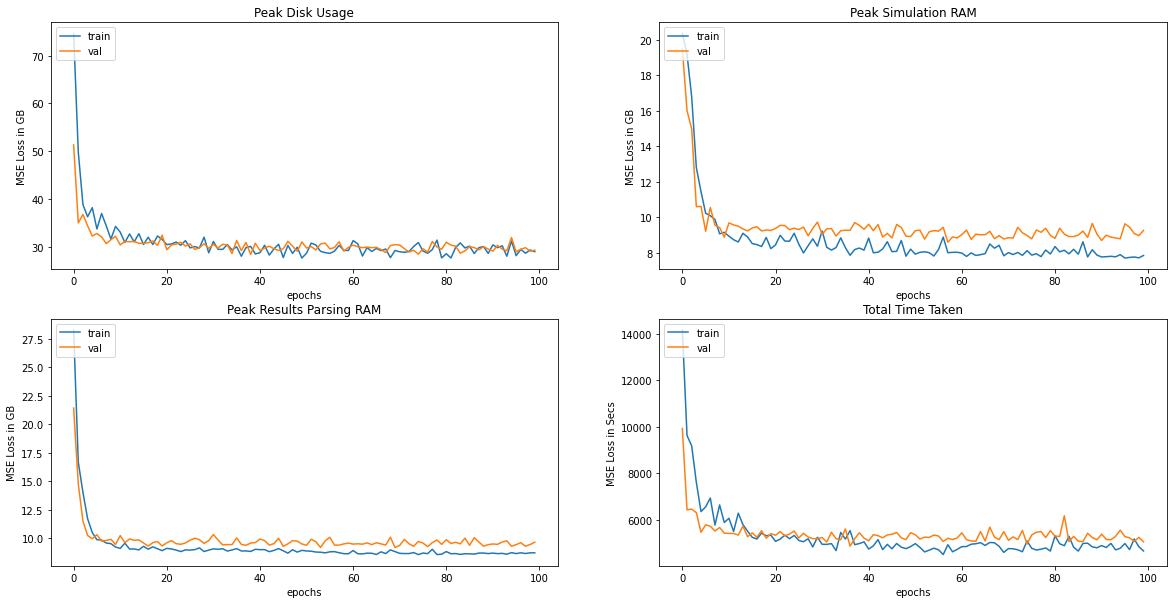

In [ ]:
# Epoch vs Loss Plots for Target Variables

plt.rcParams["figure.figsize"] = (20,10)
fig,axs = plt.subplots(2,2)

axs[0,0].plot(train_loss.iloc[:,0])
axs[0,0].plot(val_loss.iloc[:,0])
axs[0,0].set_title('Peak Disk Usage')
axs[0,0].set_xlabel('epochs')
axs[0,0].set_ylabel('MSE Loss in GB')
axs[0,0].legend(['train', 'val'], loc='upper left')

axs[0,1].plot(train_loss.iloc[:,1])
axs[0,1].plot(val_loss.iloc[:,1])
axs[0,1].set_title('Peak Simulation RAM')
axs[0,1].set_xlabel('epochs')
axs[0,1].set_ylabel('MSE Loss in GB')
axs[0,1].legend(['train', 'val'], loc='upper left')

axs[1,0].plot(train_loss.iloc[:,2])
axs[1,0].plot(val_loss.iloc[:,2])
axs[1,0].set_title('Peak Results Parsing RAM')
axs[1,0].set_xlabel('epochs')
axs[1,0].set_ylabel('MSE Loss in GB')
axs[1,0].legend(['train', 'val'], loc='upper left')

axs[1,1].plot(train_loss_time.iloc[:,3])
axs[1,1].plot(val_loss_time.iloc[:,3])
axs[1,1].set_title('Total Time Taken')
axs[1,1].set_xlabel('epochs')
axs[1,1].set_ylabel('MSE Loss in Secs')
axs[1,1].legend(['train', 'val'], loc='upper left')

# plt.set_title('Training/Validation plots')
fig.show()

In [ ]:
x = CE.predict(x_test_scaled)

In [ ]:
CE_df = pd.DataFrame(inv_boxcox1p(train_scalar2.inverse_transform(x),0.20),columns=y_test_scaled.columns,index=y_test_scaled.index)
CE_df.head()

,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec
417,7.327366e+09,2.042523e+09,1.679055e+09,976.107666
159,1.007587e+10,2.932097e+09,4.439541e+09,1624.581665
213,4.445639e+09,3.070277e+09,1.302892e+09,807.761108
532,2.205462e+10,5.487790e+09,5.078080e+09,3236.388916
177,2.555020e+10,8.225915e+09,7.843550e+09,2957.507568


In [ ]:
y_test_org  = inv_boxcox1p(y_test,0.20)
y_test_org.head()

,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec
417,4.798954e+09,1.923355e+09,1.696698e+09,404.277938
159,1.102405e+10,2.697474e+09,3.831448e+09,987.043220
213,3.104601e+08,3.196408e+09,1.015439e+08,45.240489
532,1.666004e+10,8.523235e+09,5.877092e+09,2300.200418
177,4.100225e+10,8.947331e+09,9.437041e+09,4203.869077


In [ ]:
# PERFORMANCE METRICS of the model
y1 = mean_absolute_error(y_test_org.iloc[:,0],CE_df.iloc[:,0])
print(y1*(1e-9))
y2 = mean_absolute_error(y_test_org.iloc[:,1],CE_df.iloc[:,1])
print(y2*(1e-9))
y3 = mean_absolute_error(y_test_org.iloc[:,2],CE_df.iloc[:,2])
print(y3*(1e-9))
y4 = mean_absolute_error(y_test_org.iloc[:,3],CE_df.iloc[:,3])
print(y4)

tf.Tensor(8.608894, shape=(), dtype=float32)
tf.Tensor(1.705731, shape=(), dtype=float32)
tf.Tensor(3.6331825, shape=(), dtype=float32)
tf.Tensor(935.1758, shape=(), dtype=float32)


In [ ]:
# PERFORMANCE METRICS of the model
y1 = np.sqrt(mean_squared_error(y_test_org.iloc[:,0],CE_df.iloc[:,0]))
print(y1*(1e-9))
y2 = np.sqrt(mean_squared_error(y_test_org.iloc[:,1],CE_df.iloc[:,1]))
print(y2*(1e-9))
y3 = np.sqrt(mean_squared_error(y_test_org.iloc[:,2],CE_df.iloc[:,2]))
print(y3*(1e-9))
y4 = np.sqrt(mean_squared_error(y_test_org.iloc[:,3],CE_df.iloc[:,3]))
print(y4)

22.661023744
3.4614696960000004
7.082347520000001
1609.9202


In [ ]:
#Save the  model
# pickle.dump(CE,open('NNCustEst.pkl','wb'))
# pickle.dump(train_scalar2,open('CE_TargetScalar.pkl','wb'))
# pickle.dump(train_scalar1,open('CE_FeatureScalar.pkl','wb'))

MODEL 2 (AVERAGING MODEL)

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='squared_error', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.01, max_depth=3, 
                             min_child_weight=1.5, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.01, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        self.models2 = models
        self.models3 = models
        self.models4 = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        self.models2_ = [clone(x) for x in self.models2]
        self.models3_ = [clone(x) for x in self.models3]
        self.models4_ = [clone(x) for x in self.models4]
        self.clone_models = [self.models_,self.models2_,self.models3_,self.models4_]
        # Train cloned base models
        for model,model2,model3,model4 in zip(self.models_,self.models2_,self.models3_,self.models4_):
            model.fit(X, y[0])
            model2.fit(X, y[1])
            model3.fit(X, y[2])
            model4.fit(X, y[3])
        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        predictions2 = np.column_stack([
            model.predict(X) for model in self.models2_
        ])
        predictions3 = np.column_stack([
            model.predict(X) for model in self.models3_
        ])
        predictions4 = np.column_stack([
            model.predict(X) for model in self.models4_
        ])
        return [np.mean(predictions, axis=1),np.mean(predictions2, axis=1) ,np.mean(predictions3, axis=1) ,np.mean(predictions4, axis=1)]

In [ ]:
CE2 = AveragingModels((model_xgb, GBoost, model_lgb))
start_time = time.time()
_ = CE2.fit(x_train_scaled,[y_train_scaled.iloc[:,0],y_train_scaled.iloc[:,1],y_train_scaled.iloc[:,2],y_train_scaled.iloc[:,3]])
end_time = time.time()
print(end_time-start_time)

10.374500036239624


In [ ]:
CE2_df = pd.DataFrame(inv_boxcox1p(train_scalar2.inverse_transform(pd.DataFrame(CE2.predict(x_test_scaled)).transpose()),0.20),columns=y_test_scaled.columns,index=y_test_scaled.index)
CE2_df.head()

,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec
417,9.408763e+09,2.595533e+09,3.125738e+09,826.917578
159,1.128209e+10,2.729372e+09,4.518471e+09,1106.778812
213,5.249480e+08,3.096807e+09,1.731362e+08,100.599789
532,3.581178e+10,8.326500e+09,8.475988e+09,5753.883113
177,3.135008e+10,9.463665e+09,9.314016e+09,5463.873332


In [ ]:
y_test_org = inv_boxcox1p(y_test,0.20)
y_test_org.head()

,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec
417,4.798954e+09,1.923355e+09,1.696698e+09,404.277938
159,1.102405e+10,2.697474e+09,3.831448e+09,987.043220
213,3.104601e+08,3.196408e+09,1.015439e+08,45.240489
532,1.666004e+10,8.523235e+09,5.877092e+09,2300.200418
177,4.100225e+10,8.947331e+09,9.437041e+09,4203.869077


In [ ]:
y1 = mean_absolute_error(y_test_org.iloc[:,0],CE2_df.iloc[:,0])
print(y1*(1e-9))
y2 = mean_absolute_error(y_test_org.iloc[:,1],CE2_df.iloc[:,1])
print(y2*(1e-9))
y3 = mean_absolute_error(y_test_org.iloc[:,2],CE2_df.iloc[:,2])
print(y3*(1e-9))
y4 = mean_absolute_error(y_test_org.iloc[:,3],CE2_df.iloc[:,3])
print(y4)

tf.Tensor(6.835082573202197, shape=(), dtype=float64)
tf.Tensor(0.8984260831047763, shape=(), dtype=float64)
tf.Tensor(1.3019558821579433, shape=(), dtype=float64)
tf.Tensor(1364.77060448713, shape=(), dtype=float64)


In [ ]:
# PERFORMANCE METRICS of the model
y1 = np.sqrt(mean_squared_error(y_test_org.iloc[:,0],CE2_df.iloc[:,0]))
print(y1*(1e-9))
y2 = np.sqrt(mean_squared_error(y_test_org.iloc[:,1],CE2_df.iloc[:,1]))
print(y2*(1e-9))
y3 = np.sqrt(mean_squared_error(y_test_org.iloc[:,2],CE2_df.iloc[:,2]))
print(y3*(1e-9))
y4 = np.sqrt(mean_squared_error(y_test_org.iloc[:,3],CE2_df.iloc[:,3]))
print(y4)

14.385663778569434
2.293106678784665
2.738352060683273
2676.219935530428


In [ ]:
pickle.dump(CE2,open('AVGCustEst.pkl','wb'))
# pickle.dump(train_scalar2,open('CE_TargetScalar.pkl','wb'))
# pickle.dump(train_scalar1,open('CE_FeatureScalar.pkl','wb'))

FINAL MIX

In [ ]:
probs = np.linspace(0.1,1,10)[:-1]
probs

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
DISK_maes = []
SIM_maes = []
RES_maes = []
TIME_maes = []

for prob in probs:
  temp_mix = CE_df.multiply(prob).add(CE2_df.multiply(1-prob))
  DISK_maes.append(mean_absolute_error(y_test_org.iloc[:,0],temp_mix.iloc[:,0]))
  SIM_maes.append(mean_absolute_error(y_test_org.iloc[:,1],temp_mix.iloc[:,1]))
  RES_maes.append(mean_absolute_error(y_test_org.iloc[:,2],temp_mix.iloc[:,2]))
  TIME_maes.append(mean_absolute_error(y_test_org.iloc[:,3],temp_mix.iloc[:,3]))

In [ ]:
Final_Mix = CE_df.multiply(0.3).add(CE2_df.multiply(0.7))
Final_Mix.head()

,peakdiskspaceusedbytes,peakramusedsimbytes,peakramusedresultsbytes,totaljobclocktimesec
417,8.784344e+09,2.429630e+09,2.691733e+09,871.674611
159,1.092023e+10,2.790189e+09,4.494792e+09,1262.119680
213,1.701155e+09,3.088848e+09,5.120629e+08,312.748191
532,3.168463e+10,7.474887e+09,7.456616e+09,4998.634866
177,2.961012e+10,9.092340e+09,8.872876e+09,4711.963652


In [ ]:
print(abs((y_test_org.iloc[:,0] - CE_df.iloc[:,0]).mean()))
print(abs((y_test_org.iloc[:,0] - CE2_df.iloc[:,0]).mean()))
print(abs((y_test_org.iloc[:,0] - Final_Mix.iloc[:,0]).mean()))

6220674083.525429
186475580.56878957
1996734760.4727323


In [ ]:
print('CE_df peakdisk',r2_score(y_test_org.iloc[:,0],CE_df.iloc[:,0]))
print('CE2_df peakdisk',r2_score(y_test_org.iloc[:,0],CE2_df.iloc[:,0]))
print('Final_Mix peakdisk',r2_score(y_test_org.iloc[:,0],Final_Mix.iloc[:,0]))
print(' ')
print('CE_df peakSim',r2_score(y_test_org.iloc[:,1],CE_df.iloc[:,1]))
print('CE2_df peakSim',r2_score(y_test_org.iloc[:,1],CE2_df.iloc[:,1]))
print('Final_Mix peakSim',r2_score(y_test_org.iloc[:,1],Final_Mix.iloc[:,1]))
print(' ')
print('CE_df peakRes',r2_score(y_test_org.iloc[:,2],CE_df.iloc[:,2]))
print('CE2_df peakRes',r2_score(y_test_org.iloc[:,2],CE2_df.iloc[:,2]))
print('Final_Mix peakRes',r2_score(y_test_org.iloc[:,2],Final_Mix.iloc[:,2]))
print(' ')
print('CE_df totalTime',r2_score(y_test_org.iloc[:,3],CE_df.iloc[:,3]))
print('CE2_df totalTime',r2_score(y_test_org.iloc[:,3],CE2_df.iloc[:,3]))
print('Final_Mix totalTime',r2_score(y_test_org.iloc[:,3],Final_Mix.iloc[:,3]))

CE_df peakdisk 0.8571661535768562
CE2_df peakdisk 0.9424385153548723
Final_Mix peakdisk 0.9413889860631732
 
CE_df peakSim 0.8519444154736192
CE2_df peakSim 0.9350241189143863
Final_Mix peakSim 0.9349609956336948
 
CE_df peakRes 0.763383142405618
CE2_df peakRes 0.9646271724759932
Final_Mix peakRes 0.9544706879536393
 
CE_df totalTime 0.9807670092970634
CE2_df totalTime 0.9468526332452734
Final_Mix totalTime 0.9659712778102444


In [ ]:
x = ['RandomForest','XGBoost','NeuralNetwork','AverageRegressor','Combined']
y1 = [20830591385.6,12745315450.88,mean_absolute_error(y_test_org.iloc[:,0],CE_df.iloc[:,0]),mean_absolute_error(y_test_org.iloc[:,0],CE2_df.iloc[:,0]),mean_absolute_error(y_test_org.iloc[:,0],Final_Mix.iloc[:,0])]
y1 = [y*(1e-9) for y in y1]
y2 = [3221225472,5905580032,mean_absolute_error(y_test_org.iloc[:,1],CE_df.iloc[:,1]),mean_absolute_error(y_test_org.iloc[:,1],CE2_df.iloc[:,1]),mean_absolute_error(y_test_org.iloc[:,1],Final_Mix.iloc[:,1])]
y2 = [y*(1e-9) for y in y2]
y3 = [4294967296,3435973836.8,mean_absolute_error(y_test_org.iloc[:,2],CE_df.iloc[:,2]),mean_absolute_error(y_test_org.iloc[:,2],CE2_df.iloc[:,2]),mean_absolute_error(y_test_org.iloc[:,2],Final_Mix.iloc[:,2])]
y3 = [y*(1e-9) for y in y3]
y4 = [4300,5000,mean_absolute_error(y_test_org.iloc[:,3],CE_df.iloc[:,3]),mean_absolute_error(y_test_org.iloc[:,3],CE2_df.iloc[:,3]),mean_absolute_error(y_test_org.iloc[:,3],Final_Mix.iloc[:,3])]

Text(0, 0.5, 'MAE Loss (Test) in Secs')

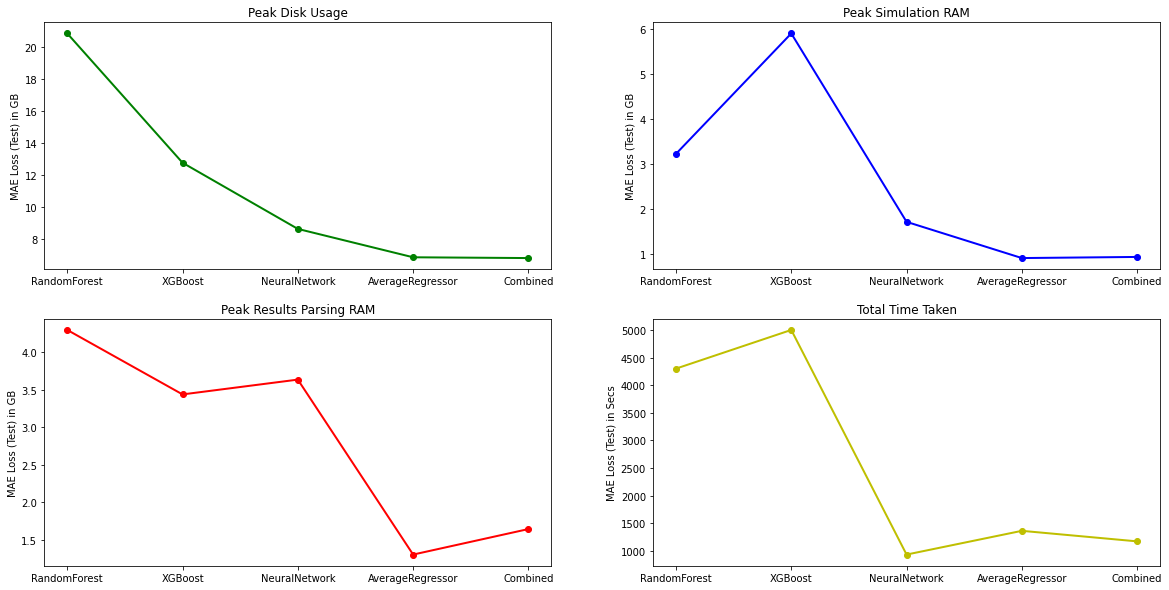

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
fig,axs = plt.subplots(2,2)

axs[0,0].plot(x, y1,'go-', label='line 1', linewidth=2)
axs[0,0].set_title('Peak Disk Usage')
# axs[0,0].set_xlabel('Models')
axs[0,0].set_ylabel('MAE Loss (Test) in GB')
# axs[0,0].legend(['train', 'val'], loc='upper left')

axs[0,1].plot(x, y2, 'bo-', label='line 1', linewidth=2)
axs[0,1].set_title('Peak Simulation RAM')
# axs[0,1].set_xlabel('Models')
axs[0,1].set_ylabel('MAE Loss (Test) in GB')
# axs[0,0].legend(['train', 'val'], loc='upper left')

axs[1,0].plot(x, y3, 'ro-', label='line 1', linewidth=2)
axs[1,0].set_title('Peak Results Parsing RAM')
# axs[1,0].set_xlabel('Models')
axs[1,0].set_ylabel('MAE Loss (Test) in GB')
# axs[0,0].legend(['train', 'val'], loc='upper left')

axs[1,1].plot(x, y4, 'yo-', label='line 1', linewidth=2)
axs[1,1].set_title('Total Time Taken')
# axs[1,1].set_xlabel('Models')
axs[1,1].set_ylabel('MAE Loss (Test) in Secs')
# axs[0,0].legend(['train', 'val'], loc='upper left')